Brian Blaylock  
July 27, 2018  
# How to apply 2D Filters on HRRR data

- https://stackoverflow.com/a/10998027/2383070
- https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.ndimage.filters.generic_filter.html

In [1]:
%matplotlib inline
import numpy as np
from datetime import datetime, timedelta
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3')
sys.path.append('B:\\pyBKB_v2')
from BB_HRRR.HRRR_Pando import get_hrrr_variable
from BB_maps.my_basemap import draw_HRRR_map
from BB_cmap.NWS_standard_cmap import cm_temp
from BB_cmap.NCAR_ensemble_cmap import cm_prob
from BB_cmap.reflectivity_cmap import reflect_ncdc

### Example 1: Sum all the boxes around each point, excluding the center point

In [2]:
# Start with an array
x = np.array([[1,2,3],
              [4,5,6],
              [7,8,9]])

print(x)
print()

# A function that sums all the values passed to it.
def test_func(values):
    print(values, '=', values.sum())
    return values.sum()

# The footprint is an array of which values to use in the filter. This footprint uses all
# the neighbooring values around a point, except for the center point.
footprint = np.array([[1,1,1],
                      [1,0,1],
                      [1,1,1]])

# The filter takes the input array x, the function we want to apply, and the footprint array.
# Mode defines how the boundaries are set. In this case the boundaries 'reflect'.
# For every point, the values for the footprint points around it are sent to the function.
# Those points are summed together and then the result returned to that same point. The final
# result is an array the same size where the footprint of each point has been manipulated by
# the function.
results2 = ndimage.generic_filter(x, test_func, footprint=footprint, mode='reflect')

print()
print(results2)

[[1 2 3]
 [4 5 6]
 [7 8 9]]

[1. 1. 2. 1. 2. 4. 4. 5.] = 20.0
[1. 2. 3. 1. 3. 4. 5. 6.] = 25.0
[2. 3. 3. 2. 3. 5. 6. 6.] = 30.0
[1. 1. 2. 4. 5. 7. 7. 8.] = 35.0
[1. 2. 3. 4. 6. 7. 8. 9.] = 40.0
[2. 3. 3. 5. 6. 8. 9. 9.] = 45.0
[4. 4. 5. 7. 8. 7. 7. 8.] = 50.0
[4. 5. 6. 7. 9. 7. 8. 9.] = 55.0
[5. 6. 6. 8. 9. 8. 9. 9.] = 60.0

[[20 25 30]
 [35 40 45]
 [50 55 60]]


### Example 2: Sum all the boxes around each point, including the center point

In [3]:
x = np.array([[1,2,3],[4,5,6],[7,8,9]])

print(x)
print()

def test_func(values):
    print(values, '=', values.sum())
    return values.sum()

# Instead of a footprint, we can define a 2d array with size (3,3).
# This is equivalent to footprint = np.array([[1,1,1],[1,1,1],[1,1,1]])
results2 = ndimage.generic_filter(x, test_func, size=(3,3), mode='reflect')

print()
print(results2)

[[1 2 3]
 [4 5 6]
 [7 8 9]]

[1. 1. 2. 1. 1. 2. 4. 4. 5.] = 21.0
[1. 2. 3. 1. 2. 3. 4. 5. 6.] = 27.0
[2. 3. 3. 2. 3. 3. 5. 6. 6.] = 33.0
[1. 1. 2. 4. 4. 5. 7. 7. 8.] = 39.0
[1. 2. 3. 4. 5. 6. 7. 8. 9.] = 45.0
[2. 3. 3. 5. 6. 6. 8. 9. 9.] = 51.0
[4. 4. 5. 7. 7. 8. 7. 7. 8.] = 57.0
[4. 5. 6. 7. 8. 9. 7. 8. 9.] = 63.0
[5. 6. 6. 8. 9. 9. 8. 9. 9.] = 69.0

[[21 27 33]
 [39 45 51]
 [57 63 69]]


### Example 2.2: Percentiles of values around each point, including the center point

In [72]:
np.zeros([3,3,3])

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

### Example 3: Apply a filter to HRRR grid with a radial footprint

In [4]:
# This funciton makes a footprint for a given radius
def radial_footprint(radius):
    y,x = np.ogrid[-radius: radius+1, -radius: radius+1]
    footprint = x**2+y**2 <= radius**2
    footprint = 1*footprint.astype(float)
    return footprint

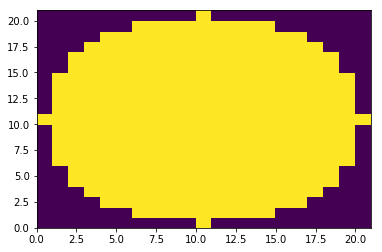

In [8]:
plt.pcolormesh(radial_footprint(10))

In [9]:
H = get_hrrr_variable(datetime(2018, 7, 30, 0), 'TMP:2 m')


 >> Dowloading tempfile: ./temp_hrrr_2018073000_f00_TMP.grib2
Oh, good, you requested a date that should be on Pando.
GRIB2 File: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20180730/hrrr.t00z.wrfsfcf00.grib2
 .idx File: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20180730/hrrr.t00z.wrfsfcf00.grib2.idx
 >> Matched a variable:  66:34565037:d=2018073000:TMP:2 m above ground:anl:
 >> Byte Range: 34565037 35835053


In [10]:
# Apply a spatial filter that computes the mean temperature for the radial footprint
def radial_mean(values):
    return np.mean(values)

In [11]:
r = 10
result_radial_mean = ndimage.generic_filter(H['value'], radial_mean, footprint=radial_footprint(r))

In [12]:
m = draw_HRRR_map()

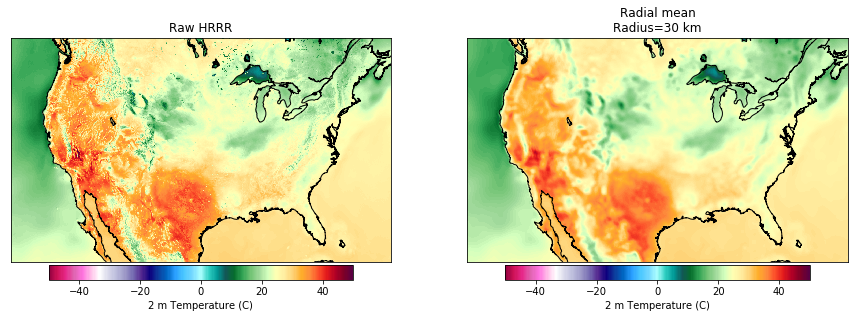

In [13]:
cm = cm_temp()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[15,5])
plt.sca(ax1)
m.pcolormesh(H['lon'], H['lat'], H['value']-273.15, cmap=cm['cmap'], vmax=cm['vmax'], vmin=cm['vmin'], latlon=True)
m.drawcoastlines()
cb = plt.colorbar(orientation='horizontal', pad=.01, shrink=.8)
cb.set_label('2 m Temperature (C)')
plt.title('Raw HRRR');

plt.sca(ax2)
m.pcolormesh(H['lon'], H['lat'], result_radial_mean-273.15, cmap=cm['cmap'], vmax=cm['vmax'], vmin=cm['vmin'], latlon=True)
m.drawcoastlines()
cb = plt.colorbar(orientation='horizontal', pad=.01, shrink=.8)
cb.set_label('2 m Temperature (C)')
plt.title('Radial mean\nRadius=%s km' % (r*3)); # * 3 becuase each grid point is 3 km


### Example 3: Occurrence of reflectivity greater than 35 dBZ
Based on the Time-Lagged Ensemble, computing the spatial probability requires two filters. One to assing adjacent points within the footprint as a "hit" to ensure that the center point has 100% probability of occurance. This is the initial step for computing a Time-Lagged Ensemble. The second to cound up the number of "hits" within the radius.
See more here: https://rapidrefresh.noaa.gov/internal/pdfs/alcott_HRRRTLE_8jun2016-adj.pdf

In [14]:
H = get_hrrr_variable(datetime(2018, 7, 17, 6), 'REFC:entire')


 >> Dowloading tempfile: ./temp_hrrr_2018071706_f00_REF.grib2
Oh, good, you requested a date that should be on Pando.
GRIB2 File: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20180717/hrrr.t06z.wrfsfcf00.grib2
 .idx File: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20180717/hrrr.t06z.wrfsfcf00.grib2.idx
 >> Matched a variable:  1:0:d=2018071706:REFC:entire atmosphere:anl:
 >> Byte Range: 0 353722


In [30]:
def first_filter(values):
    '''
    If the pixel is over the threshold, then set all surrounding pixels as 
    above the threshold. This ensures that this pixel will receive 100%
    probability that it will be over the threshold. We do this with a filter.
    If any pixel within the radius exceeds the threshold, then that point is
    set to exceed the threshold.
    '''
    return np.max(values) >= 35

def second_filter(values):
    '''
    The second filter sums up the amount of points in the radius
    '''
    return np.sum(values)

In [55]:
# Radius and threshold value to filter
r = 9

# Execute first filter
first_result = ndimage.generic_filter(H['value'], first_filter, footprint=radial_footprint(r))

In [56]:
second_result = ndimage.generic_filter(first_result, second_filter, footprint=radial_footprint(r))

In [57]:
# Probability is occurrences, comuted from second filter, divided by the number of points in the radial footprint
probability = second_result/np.sum(radial_footprint(r))

Text(0.5,0.98,'Radius = 27 km')

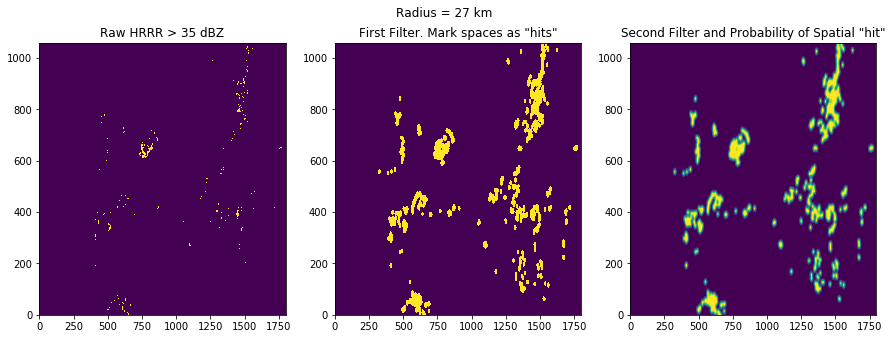

In [58]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[15,5])
plt.sca(ax1)
plt.pcolormesh(H['value']>35)
plt.title('Raw HRRR > 35 dBZ')
plt.sca(ax2)
plt.pcolormesh(first_result)
plt.title('First Filter. Mark spaces as "hits"')
plt.sca(ax3)
plt.pcolormesh(probability)
plt.title('Second Filter and Probability of Spatial "hit"')

plt.suptitle("Radius = %s km" % (r*3)) # r*3 because each grid point is 3 km

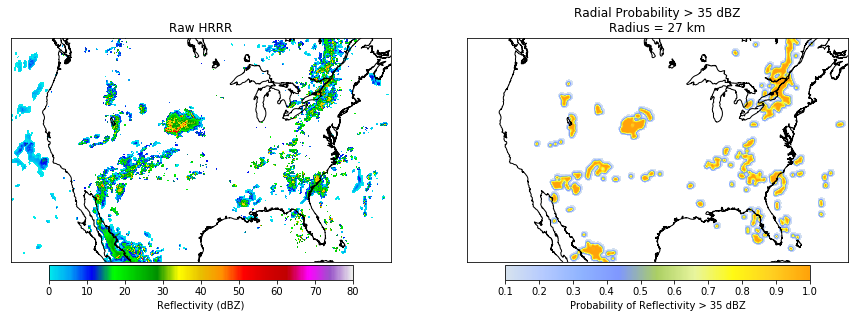

In [60]:
# Load custom colormaps
cm = reflect_ncdc()
cmp = cm_prob()

# Mask out points with no reflectivity
masked = H['value']
masked = np.ma.array(masked)
masked[masked <= 0] = np.ma.masked

# Mask non-reflectivity points in probability
masked_p = probability
masked_p = np.ma.array(masked_p)
masked_p[masked_p <= .1] = np.ma.masked


fig, (ax1, ax2) = plt.subplots(1,2, figsize=[15,5])
plt.sca(ax1)
m.pcolormesh(H['lon'], H['lat'], masked, cmap=cm['cmap'], vmax=cm['vmax'], vmin=cm['vmin'], latlon=True)
m.drawcoastlines()
cb = plt.colorbar(orientation='horizontal', pad=.01, shrink=.8)
cb.set_label('Reflectivity (dBZ)')
plt.title('Raw HRRR');

plt.sca(ax2)
m.pcolormesh(H['lon'], H['lat'], masked_p, cmap=cmp['cmap'], vmax=cmp['vmax'], vmin=cmp['vmin'], latlon=True)
m.drawcoastlines()
cb = plt.colorbar(orientation='horizontal', pad=.01, shrink=.8)
cb.set_label('Probability of Reflectivity > 35 dBZ')
plt.title('Radial Probability > 35 dBZ\nRadius = %s km' % (r*3)); # r * 3 becuase each grid point is 3 km


The HRRR Time-Lagged Ensemble is the mean of several model runs that are valid at the same time, i.e. mean of f02, f03, and f04 probabilities.